In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

train = pd.read_csv("../data/processed/tcr_epitope_dataset.csv")
train = train.dropna(subset=["cdr3b", "epitope", "label"])

aa_list = list("ACDEFGHIKLMNPQRSTVWY")  
aa_to_int = {aa:i for i,aa in enumerate(aa_list)}

In [4]:
def seq_to_ints(seq, maxlen):
    seq = [aa_to_int.get(a, -1) for a in seq]  
    seq = [x for x in seq if x >= 0]  
    return seq[:maxlen]  

max_tcr, max_epi = 25, 9
X_tcr = [seq_to_ints(s, max_tcr) for s in train["cdr3b"]]
X_epi = [seq_to_ints(s, max_epi) for s in train["epitope"]]

X_tcr = pad_sequences(X_tcr, maxlen=max_tcr, padding="post", value=-1)
X_epi = pad_sequences(X_epi, maxlen=max_epi, padding="post", value=-1)

X_all = np.hstack([X_tcr, X_epi])

In [33]:
enc = OneHotEncoder(categories=[list(range(len(aa_list)))]*(max_tcr+max_epi), handle_unknown="ignore", sparse_output=False)
X = enc.fit_transform(X_all)

y = train["label"].astype(int).values

X.shape

(64827, 680)

In [36]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs, aprs = [], []

for tr, te in kf.split(X, y):
    model = LogisticRegression(max_iter=200)
    model.fit(X[tr], y[tr])
    preds = model.predict_proba(X[te])[:,1]
    aucs.append(roc_auc_score(y[te], preds))
    aprs.append(average_precision_score(y[te], preds))

print("AUROC %.3f ± %.3f | AUPR %.3f ± %.3f" % (
    np.mean(aucs), np.std(aucs), np.mean(aprs), np.std(aprs)
))

AUROC 0.876 ± 0.005 | AUPR 0.715 ± 0.011


In [7]:
final_model = LogisticRegression(max_iter=200)
final_model.fit(X, y)

test = pd.read_csv("/users/huiwang/project/data/raw/test.csv")
X_tcr_test = [seq_to_ints(str(s), max_tcr) for s in test["CDR3b"]]
X_epi_test = [seq_to_ints(str(s), max_epi) for s in test["Peptide"]]
X_tcr_test = pad_sequences(X_tcr_test, maxlen=max_tcr, padding="post", value=-1)
X_epi_test = pad_sequences(X_epi_test, maxlen=max_epi, padding="post", value=-1)
X_test_all = np.hstack([X_tcr_test, X_epi_test])
X_test = enc.transform(X_test_all)

test_preds = final_model.predict_proba(X_test)[:,1]

In [17]:
submission = pd.DataFrame({
    "ID": test["ID"],
    "Prediction": test_preds
})
submission.to_csv("/users/huiwang/project/data/processed/submission_onehot.csv", index=False)

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, average_precision_score,
                             confusion_matrix, classification_report, brier_score_loss)
from sklearn.calibration import calibration_curve

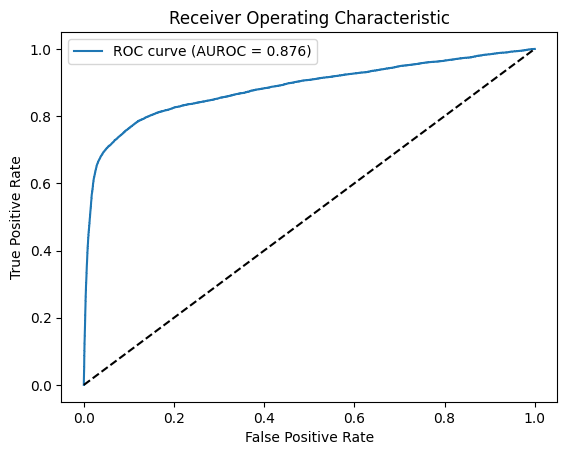

In [26]:
fpr, tpr, _ = roc_curve(y, final_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (AUROC = %.3f)" % np.mean(aucs))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Receiver Operating Characteristic")
plt.savefig("/users/huiwang/project/figs/track2_reciever_operating_characteristic.png", dpi=150)
plt.show()

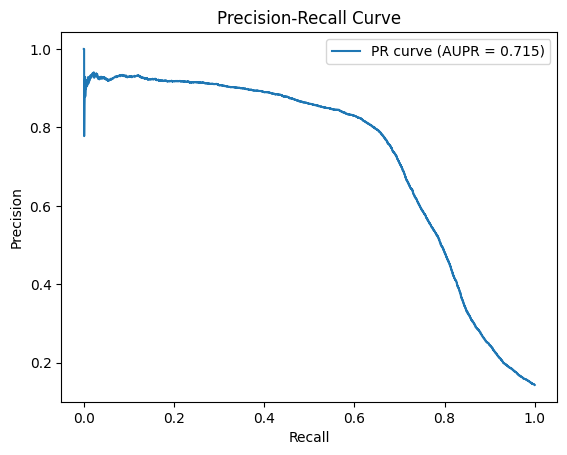

In [25]:
prec, rec, _ = precision_recall_curve(y, final_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(rec, prec, label="PR curve (AUPR = %.3f)" % np.mean(aprs))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")
plt.savefig("/users/huiwang/project/figs/track2_precision_recall_curve.png", dpi=150)
plt.show()

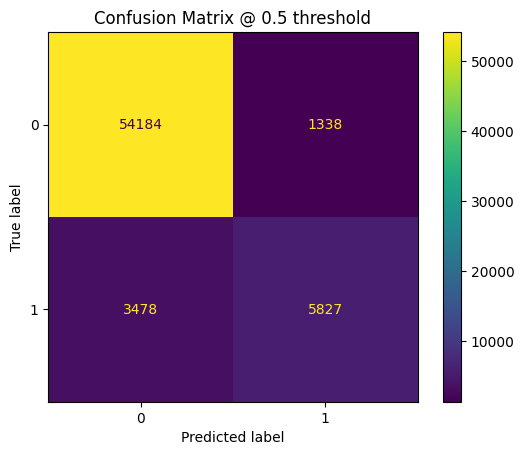

In [24]:
y_pred_bin = (final_model.predict_proba(X)[:,1] >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix @ 0.5 threshold")
plt.savefig("/users/huiwang/project/figs/track2_confusion_matrix.png", dpi=150)
plt.show()

In [12]:
subset_idx = np.random.choice(len(X), size=min(2000, len(X)), replace=False)
X_subset = X[subset_idx]
y_subset = y[subset_idx]

In [32]:
submission_full = test.copy()
submission_full["Prediction"] = test_preds
submission_full.to_csv("../data/processed/submission_onehot_full.csv", index=False)

In [21]:
y_score_train = final_model.predict_proba(X)[:,1]
fpr, tpr, _ = roc_curve(y, y_score_train)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y, y_score_train)
pr_auc = average_precision_score(y, y_score_train)

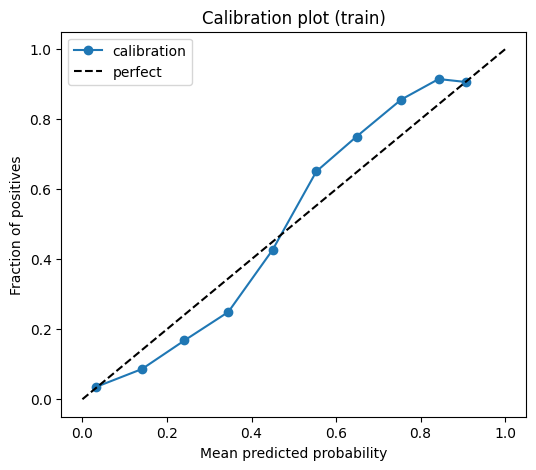

In [23]:
prob_true, prob_pred = calibration_curve(y, y_score_train, n_bins=10)
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='calibration')
plt.plot([0,1],[0,1],'k--', label='perfect')
plt.xlabel('Mean predicted probability'); plt.ylabel('Fraction of positives')
plt.title('Calibration plot (train)')
plt.legend()
plt.savefig("/users/huiwang/project/figs/track2_calibration_train.png", dpi=150)
plt.show()

In [28]:
youden_idx = np.argmax(tpr - fpr)
optimal_thresh = _[youden_idx] if len(_) > youden_idx else 0.5  # safety
fpr_all, tpr_all, thr_all = roc_curve(y, y_score_train)
youden_idx = np.argmax(tpr_all - fpr_all)
optimal_thresh = thr_all[youden_idx]
print("Optimal threshold (Youden):", optimal_thresh)

Optimal threshold (Youden): 0.17414145215038343


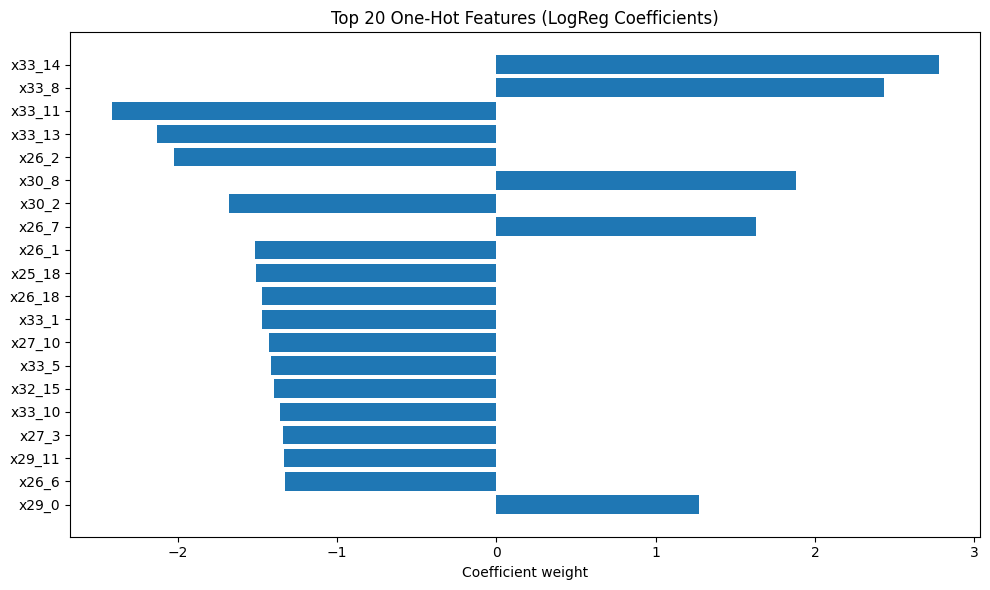

In [32]:
try:
    feature_names = enc.get_feature_names_out()
except:
    feature_names = [f"feat_{i}" for i in range(X.shape[1])]

coefs = final_model.coef_[0]
top_idx = np.argsort(np.abs(coefs))[::-1][:20]

plt.figure(figsize=(10,6))
plt.barh(range(len(top_idx)), coefs[top_idx])
plt.yticks(range(len(top_idx)), [feature_names[i] for i in top_idx])
plt.gca().invert_yaxis()
plt.title("Top 20 One-Hot Features (LogReg Coefficients)")
plt.xlabel("Coefficient weight")
plt.tight_layout()
plt.savefig("/users/huiwang/project/figs/track2_top_features.png")
plt.show()